# Recommender Systems


## Imports


In [ ]:
%pip install numpy==1.23.5
%pip install scikit-surprise

In [99]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score
from surprise import Reader, AlgoBase, Dataset, accuracy
from surprise import SVD, KNNBaseline

In [27]:
SEED = 42
np.random.seed(SEED)

# Set plot styling
plt.style.use("ggplot")
sns.set(style="whitegrid")

## Load Data


In [36]:
# Load each CSV into a DataFrame
df = pd.read_csv("optimized_df.csv")
df.head(2)

,review_id,user_id,restaurant_id,overall_score,overall_magnitude,food_score,service_score,value_score,ambiance_score,emotions,...,address_line3,latitude,longitude,hours_monday,hours_tuesday,hours_wednesday,hours_thursday,hours_friday,hours_saturday,hours_sunday
0,100000032416892623125_115827996910815192564,100000032416892623125,115827996910815192564,0.7964,0.470,0.457906,0.0,0.0,0.0,['satisfaction'],...,NaN,40.175064,-122.242574,11:00 am--9:00 pm,11:00 am--9:00 pm,11:00 am--9:00 pm,11:00 am--9:00 pm,11:00 am--9:00 pm,11:00 am--9:00 pm,11:00 am--9:00 pm
1,100000202208212354964_103340747374180675968,100000202208212354964,103340747374180675968,-0.2158,0.017,0.000000,0.0,0.0,0.0,['disappointment'],...,NaN,35.894768,-78.745868,7:30 am--5:00 pm,7:30 am--5:00 pm,7:30 am--5:00 pm,7:30 am--5:00 pm,7:30 am--5:00 pm,Closed,Closed


## Test/Train Split

Implementing a **user stratified split** to ensure users in the test set also appear in the training set

In [37]:
def create_user_stratified_split(df, test_size=0.2, random_state=42):
    """
    Create a user-stratified train-test split for a recommendation dataset.
    This ensures users in the test set also appear in the training set.

    Args:
        df: DataFrame with user_id and other columns
        test_size: Proportion of data to include in the test set
        random_state: Random seed for reproducibility

    Returns:
        train_df, test_df: DataFrames for training and testing
    """
    np.random.seed(random_state)

    # Get users with their rating counts
    user_counts = df["user_id"].value_counts().reset_index()
    user_counts.columns = ["user_id", "rating_count"]

    # Separate users with multiple ratings and users with single rating
    multi_rating_users = user_counts[user_counts["rating_count"] > 1]["user_id"].values
    single_rating_users = user_counts[user_counts["rating_count"] == 1][
        "user_id"
    ].values

    print(f"Users with multiple ratings: {len(multi_rating_users)}")
    print(f"Users with a single rating: {len(single_rating_users)}")

    train_indices = []
    test_indices = []

    # For users with multiple ratings, split their ratings between train and test sets
    for user in multi_rating_users:
        user_indices = df[df["user_id"] == user].index.tolist()

        # Ensure at least one rating goes to train
        n_test = max(1, int(len(user_indices) * test_size))
        n_train = len(user_indices) - n_test

        # If user has only two ratings, ensure one goes to each set
        if len(user_indices) == 2:
            n_test = 1
            n_train = 1

        # Randomly select indices for test set
        user_test_indices = np.random.choice(user_indices, size=n_test, replace=False)
        user_train_indices = list(set(user_indices) - set(user_test_indices))

        train_indices.extend(user_train_indices)
        test_indices.extend(user_test_indices)

    # Calculate target test size and how many more samples we need
    target_test_size = int(len(df) * test_size)
    additional_test_samples_needed = max(0, target_test_size - len(test_indices))

    # Determine how many single-rating users should go to test set
    n_single_for_test = min(additional_test_samples_needed, len(single_rating_users))

    if n_single_for_test > 0:
        # Randomly select users with single ratings for test set
        test_single_users = np.random.choice(
            single_rating_users, size=n_single_for_test, replace=False
        )

        # Convert to a set for faster lookups
        test_single_users_set = set(test_single_users)

        # Add indices to train and test sets
        for user in single_rating_users:
            user_idx = df[df["user_id"] == user].index[0]
            if user in test_single_users_set:
                test_indices.append(user_idx)
            else:
                train_indices.append(user_idx)
    else:
        # All single-rating users go to train set
        for user in single_rating_users:
            user_idx = df[df["user_id"] == user].index[0]
            train_indices.append(user_idx)

    # Create the train and test dataframes
    train_df = df.iloc[train_indices].copy().reset_index(drop=True)
    test_df = df.iloc[test_indices].copy().reset_index(drop=True)

    print(f"Train set size: {len(train_df)} ({len(train_df) / len(df):.2%})")
    print(f"Test set size: {len(test_df)} ({len(test_df) / len(df):.2%})")

    return train_df, test_df

In [38]:
# Create train-test split
# Check if 'rating_final' exists, if not, create it from 'rating'
if "rating_final" not in df.columns and "rating" in df.columns:
    print("Creating 'rating_final' column from 'rating' column")
    df["rating_final"] = df["rating"]

# Create train-test split
train_df, test_df = create_user_stratified_split(df, test_size=0.2, random_state=SEED)

# Verify the split
train_users = set(train_df["user_id"].unique())
test_users = set(test_df["user_id"].unique())
overlap_users = train_users.intersection(test_users)

print(f"\nUsers in train set: {len(train_users)}")
print(f"Users in test set: {len(test_users)}")
print(f"Users in both train and test: {len(overlap_users)}")
print(
    f"Percentage of test users also in train: {len(overlap_users) / len(test_users):.2%}"
)

# Check restaurant overlap
train_restaurants = set(train_df["restaurant_id"].unique())
test_restaurants = set(test_df["restaurant_id"].unique())
overlap_restaurants = train_restaurants.intersection(test_restaurants)

print(f"\nRestaurants in train set: {len(train_restaurants)}")
print(f"Restaurants in test set: {len(test_restaurants)}")
print(f"Restaurants in both train and test: {len(overlap_restaurants)}")
print(
    f"Percentage of test restaurants also in train: {len(overlap_restaurants) / len(test_restaurants):.2%}"
)

# Make sure all required columns are present for Surprise
required_columns = ["user_id", "restaurant_id", "rating_final"]
for col in required_columns:
    if col not in train_df.columns:
        print(f"ERROR: {col} missing from dataset")

Creating 'rating_final' column from 'rating' column
Users with multiple ratings: 3920
Users with a single rating: 2536
Train set size: 19439 (78.38%)
Test set size: 5362 (21.62%)

Users in train set: 6456
Users in test set: 3920
Users in both train and test: 3920
Percentage of test users also in train: 100.00%

Restaurants in train set: 9566
Restaurants in test set: 4392
Restaurants in both train and test: 4010
Percentage of test restaurants also in train: 91.30%


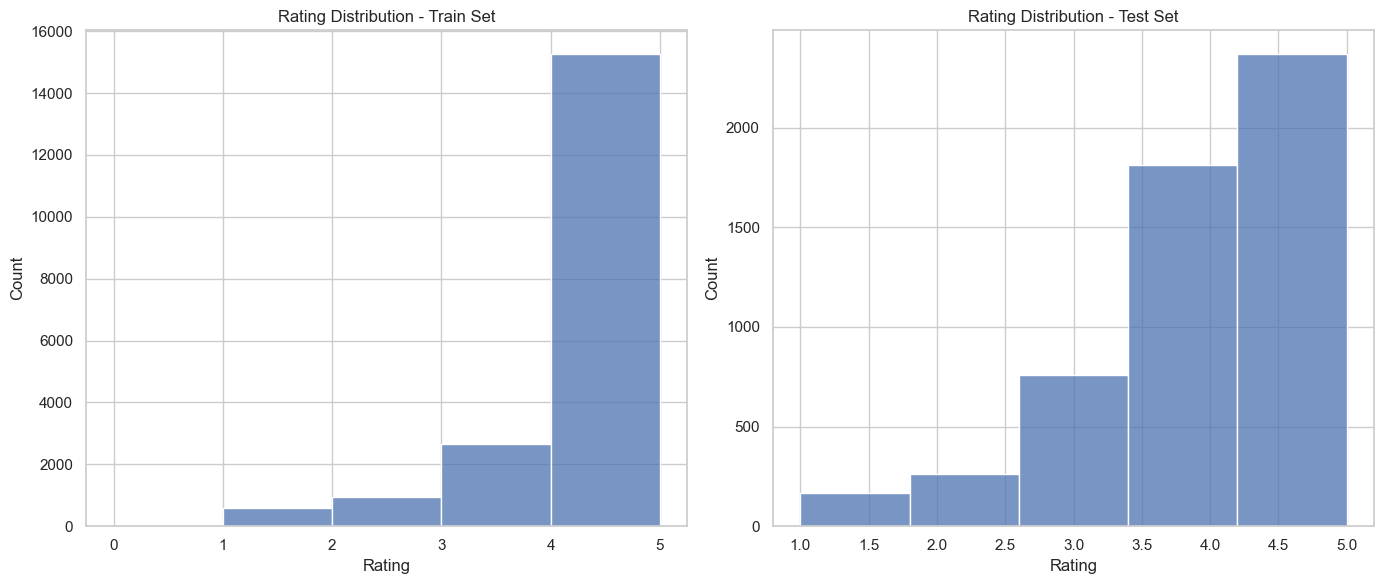

In [41]:
# Visualize rating distributions between train and test sets
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x="rating_final", bins=5)
plt.title("Rating Distribution - Train Set")
plt.xlabel("Rating")

plt.subplot(1, 2, 2)
sns.histplot(data=test_df, x="rating_final", bins=5)
plt.title("Rating Distribution - Test Set")
plt.xlabel("Rating")

plt.tight_layout()
plt.show()

### Surprise Dataset Conversion

In [43]:
reader = Reader(rating_scale=(1, 5))

# Create the Surprise Dataset from the train and test dataframes
trainset = Dataset.load_from_df(
    train_df[["user_id", "restaurant_id", "rating_final"]], reader
).build_full_trainset()

testset = (
    Dataset.load_from_df(test_df[["user_id", "restaurant_id", "rating_final"]], reader)
    .build_full_trainset()
    .build_testset()
)

print("Conversion to Surprise Dataset complete")

Conversion to Surprise Dataset complete


## Recommenders


### Random


In [44]:
class MyRandomRecommender(AlgoBase):
    """
    Random recommender based on the normal distribution of ratings.
    """

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        """
        Predict a random rating from the normal distribution.
        Note: u and i are not used as this is non-personalized.
        """
        return np.random.normal(loc=self.train_mean, scale=self.train_std)

    def fit(self, trainset):
        """
        Train the algorithm on the trainset.
        """
        AlgoBase.fit(self, trainset)

        # Calculate mean and standard deviation of all ratings
        ratings = [r for (_, _, r) in self.trainset.all_ratings()]
        self.train_mean = np.mean(ratings)
        self.train_std = np.std(ratings)

        return self


random_RS = MyRandomRecommender()

### Popular


In [45]:
class MyPopularRecommender(AlgoBase):
    """
    Popularity-based recommender that predicts the average rating for each item.
    """

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        """
        Predict the average rating for item i.
        Note: u is not used as this is non-personalized.
        """
        # Convert internal item id to raw item id
        try:
            raw_iid = self.trainset.to_raw_iid(i)
        except ValueError:
            # If item not in training set, return global mean
            return self.trainset.global_mean

        if raw_iid in self.mean_rating_per_item_df.index:
            return self.mean_rating_per_item_df.loc[raw_iid]["rating"]
        else:
            # For items not in training set, return global mean
            return self.trainset.global_mean

    def fit(self, trainset):
        """
        Train the algorithm on the trainset.
        """
        AlgoBase.fit(self, trainset)

        # Convert internal ids to raw ids for better readability
        ratings_list = [
            (self.trainset.to_raw_iid(i), r)
            for (_, i, r) in self.trainset.all_ratings()
        ]

        # Create DataFrame of all ratings
        ratings_df = pd.DataFrame(ratings_list, columns=["item", "rating"])

        # Calculate mean rating per item
        self.mean_rating_per_item_df = ratings_df.groupby("item").agg(
            {"rating": "mean"}
        )

        return self


popular_RS = MyPopularRecommender()

### Collaborative Filtering


#### SVD

In [57]:
cf_RS = SVD(
    n_factors=100,  # Number of latent factors
    n_epochs=20,  # Number of iterations over the training data
    lr_all=0.005,  # Learning rate for all parameters
    reg_all=0.02,  # Regularization term for all parameters
    random_state=SEED,
)

#### User-Based CF

In [88]:
user_based_CF = KNNBaseline(
    k=40,
    min_k=1,
    sim_options={
        "name": "cosine",
        "user_based": True,
        "min_support": 3,  # Require at least 3 common items
    },
)

### Item-Based CF

In [89]:
item_based_CF = KNNBaseline(
    k=40,
    min_k=1,
    sim_options={
        "name": "cosine",
        "user_based": False,
        "min_support": 3,  # Require at least 3 common users
    },
)

### Content Based


### Context Aware


### Armed Bandits


### Hybrid


## Cross Validation

In [ ]:
# Create cross-validation folds for later use
def create_user_folds(df, n_splits=5):
    """
    Create cross-validation folds stratified by user

    Args:
        df: DataFrame with 'user_id' and rating data
        n_splits: Number of folds
        random_state: Random seed for reproducibility

    Returns:
        List of (train_idx, test_idx) for each fold
    """
    # Initialize group k-fold
    group_kfold = GroupKFold(n_splits=n_splits)

    # Use user as the group
    groups = df["user_id"].values

    # Generate train/test indices for each fold
    folds = list(group_kfold.split(df, groups=groups))

    return folds


# Create CV folds
cv_folds = create_user_folds(train_df, n_splits=5)

# Count users and ratings in each fold
fold_stats = []
for fold_idx, (train_idx, test_idx) in enumerate(cv_folds):
    train_fold = train_df.iloc[train_idx]
    test_fold = train_df.iloc[test_idx]

    train_users = train_fold["user_id"].nunique()
    test_users = test_fold["user_id"].nunique()
    common_users = len(
        set(train_fold["user_id"]).intersection(set(test_fold["user_id"]))
    )

    fold_stats.append(
        {
            "Fold": fold_idx + 1,
            "Train Ratings": len(train_fold),
            "Test Ratings": len(test_fold),
            "Train Users": train_users,
            "Test Users": test_users,
            "Common Users": common_users,
            "User Coverage": common_users / train_users * 100,
        }
    )

fold_stats_df = pd.DataFrame(fold_stats)
print("\nCross-validation fold statistics:")
print(fold_stats_df)

## Evaluation


In [ ]:
# Generate predictions for each model and store them
model_predictions = {}

k_values = [5, 10, 20]

models = {
    "Popular": popular_RS,
    "Random": random_RS,
    "SVD": cf_RS,
    "User-Based CF": user_based_CF,
    "Item-Based CF": item_based_CF,
}

for model_name, model in models.items():
    model_predictions[model_name] = model.test(testset)

print("Generated model predictions")

### Test RMSE


In [68]:
start_time = time.time()
random_RS.fit(trainset)
predictions_random = random_RS.test(testset)
random_time = time.time() - start_time

print(
    f"RMSE - Random Recommender: {accuracy.rmse(predictions_random, verbose=False):.4f}"
)
print(f"Training time: {random_time:.2f}s")

RMSE - Random Recommender: 1.3423
Training time: 0.02s


In [69]:
start_time = time.time()
popular_RS.fit(trainset)
predictions_popular = popular_RS.test(testset)
popular_time = time.time() - start_time

print(
    f"RMSE - Popular Recommender: {accuracy.rmse(predictions_popular, verbose=False):.4f}"
)
print(f"Training time: {popular_time:.2f}s")

RMSE - Popular Recommender: 1.1951
Training time: 0.16s


In [71]:
start_time = time.time()
cf_RS.fit(trainset)
predictions_cf = cf_RS.test(testset)
cf_time = time.time() - start_time

print(f"RMSE - CF SVD: {accuracy.rmse(predictions_cf, verbose=False):.4f}")
print(f"Training time: {cf_time:.2f}s")

RMSE - CF SVD: 0.9700
Training time: 0.13s


In [90]:
start_time = time.time()
user_based_CF.fit(trainset)
predictions_user_based = user_based_CF.test(testset)
user_based_time = time.time() - start_time

print(f"User-Based CF RMSE: {accuracy.rmse(predictions_user_based, verbose=False):.4f}")
print(f"Training time: {user_based_time:.2f}s")

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
User-Based CF RMSE: 0.9854
Training time: 0.37s


In [91]:
start_time = time.time()
item_based_CF.fit(trainset)
predictions_item_based = item_based_CF.test(testset)
item_based_time = time.time() - start_time

print(f"Item-Based CF RMSE: {accuracy.rmse(predictions_item_based, verbose=False):.4f}")
print(f"Training time: {item_based_time:.2f}s")

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Item-Based CF RMSE: 0.9739
Training time: 0.83s


In [206]:
# Calculate metrics once for all models
metrics = {}
for model_name, predictions in model_predictions.items():
    metrics[model_name] = {
        "rmse": accuracy.rmse(predictions, verbose=False),
        "mae": accuracy.mae(predictions, verbose=False),
    }

# Print the metrics table
print("\n=== RMSE and MAE ===")
for model_name, model_metrics in metrics.items():
    print(
        f"{model_name:<15} RMSE: {model_metrics['rmse']:.4f}, MAE: {model_metrics['mae']:.4f}"
    )


=== RMSE and MAE ===
Popular         RMSE: 1.1951, MAE: 0.8407
Random          RMSE: 1.3200, MAE: 1.0226
SVD             RMSE: 0.9700, MAE: 0.7491
User-Based CF   RMSE: 0.9854, MAE: 0.7589
Item-Based CF   RMSE: 0.9739, MAE: 0.7510


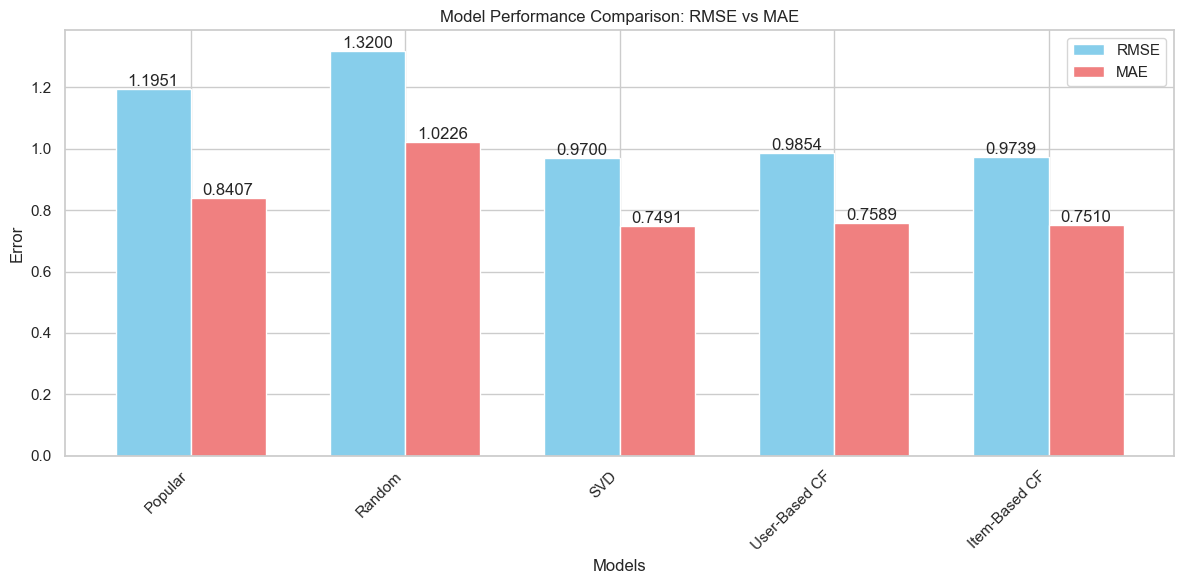

In [207]:
# Prepare data for plotting
models = list(metrics.keys())
rmse_values = [metrics[model]["rmse"] for model in models]
mae_values = [metrics[model]["mae"] for model in models]

# Set up the bar positions
x = np.arange(len(models))
width = 0.35

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, rmse_values, width, label="RMSE", color="skyblue")
plt.bar(x + width / 2, mae_values, width, label="MAE", color="lightcoral")

# Customize the chart
plt.xlabel("Models")
plt.ylabel("Error")
plt.title("Model Performance Comparison: RMSE vs MAE")
plt.xticks(x, models, rotation=45, ha="right")
plt.legend()

# Add value labels on top of each bar
for i, v in enumerate(rmse_values):
    plt.text(i - width / 2, v, f"{v:.4f}", ha="center", va="bottom")
for i, v in enumerate(mae_values):
    plt.text(i + width / 2, v, f"{v:.4f}", ha="center", va="bottom")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

#### Recommendation Distribution Comparison

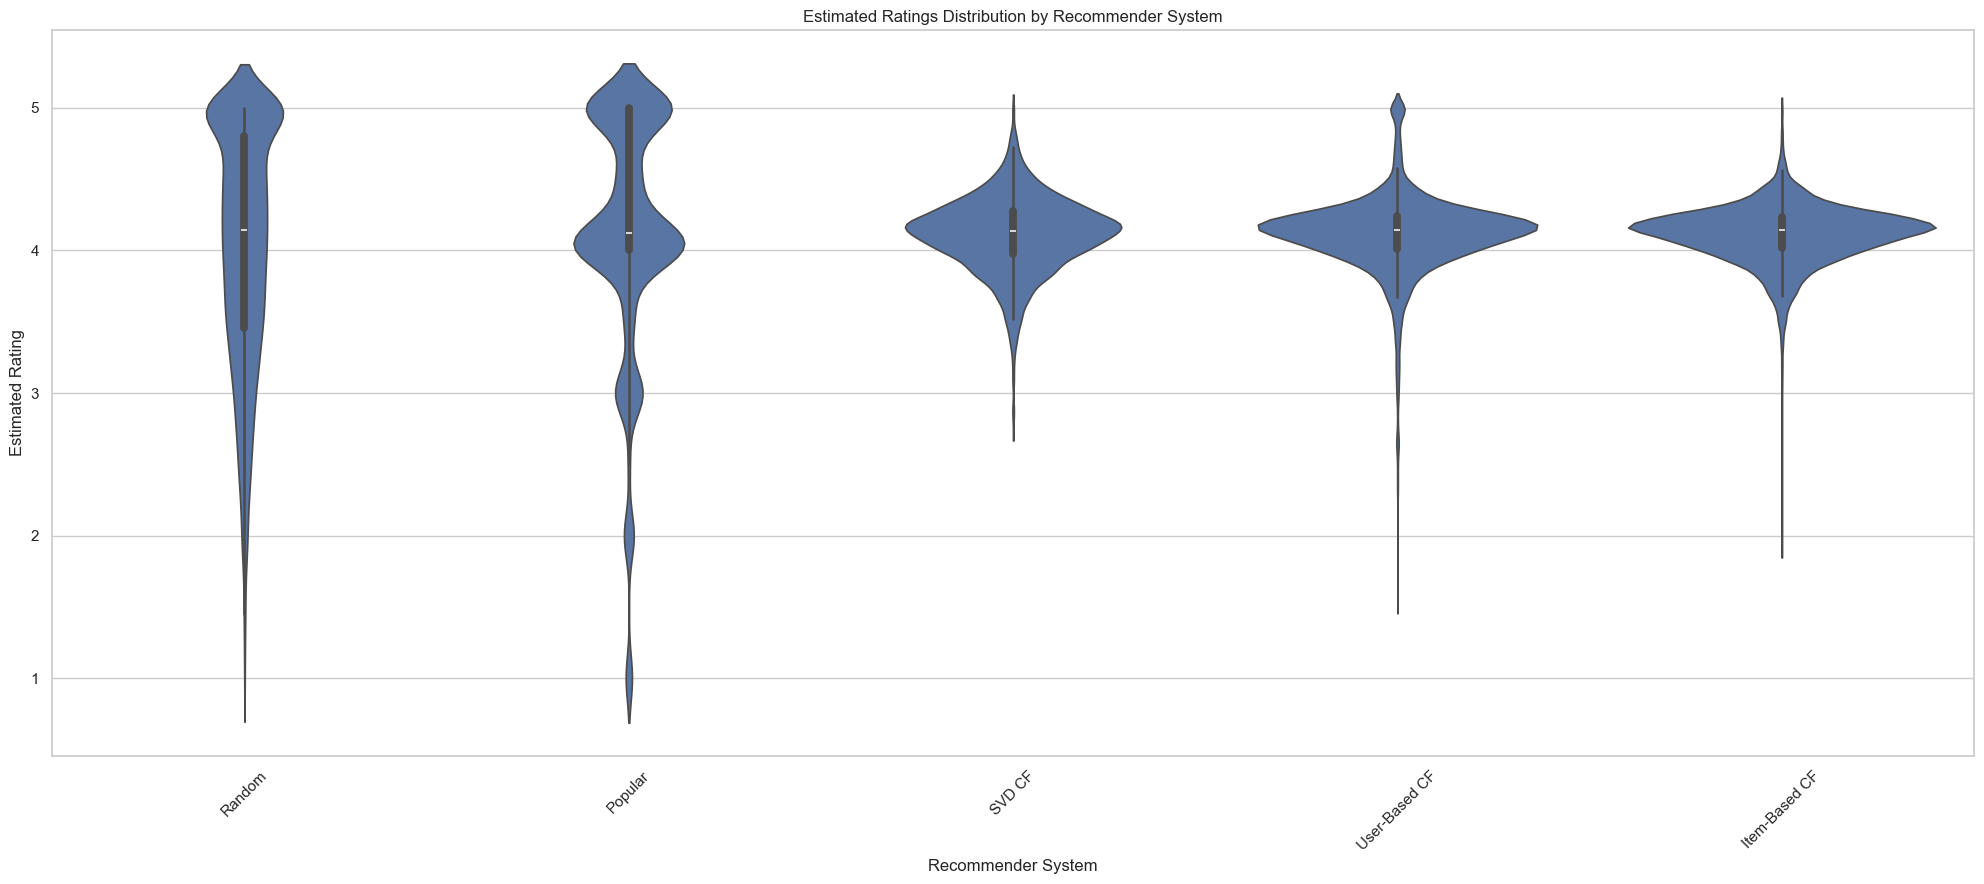

In [92]:
def get_ratings_df(predictions):
    ratings = []
    for pred in predictions:
        ratings.append(
            {
                "uid": pred.uid,
                "iid": pred.iid,
                "r_ui": pred.r_ui,
                "est": pred.est,
                "details": pred.details,
            }
        )
    return pd.DataFrame(ratings)


random_ratings_df = get_ratings_df(predictions_random)
popular_ratings_df = get_ratings_df(predictions_popular)
cf_ratings_df = get_ratings_df(predictions_cf)
user_based_ratings_df = get_ratings_df(predictions_user_based)
item_based_ratings_df = get_ratings_df(predictions_item_based)

# Combine all ratings into a single dataframe for easier plotting
all_cf_ratings = pd.concat(
    [
        random_ratings_df.assign(RS="Random"),
        popular_ratings_df.assign(RS="Popular"),
        cf_ratings_df.assign(RS="SVD CF"),
        user_based_ratings_df.assign(RS="User-Based CF"),
        item_based_ratings_df.assign(RS="Item-Based CF"),
    ]
)

# Visualize the distribution of estimated ratings
plt.figure(figsize=(20, 9))
sns.violinplot(x="RS", y="est", data=all_cf_ratings)
plt.title("Estimated Ratings Distribution by Recommender System")
plt.xlabel("Recommender System")
plt.ylabel("Estimated Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Quality Metrics


In [194]:
# Define metric functions
def calculate_ndcg_at_k(predictions, k=10):
    """Calculate NDCG@k for a set of predictions."""
    user_est_true = defaultdict(list)
    for uid, _, r_ui, est, _ in predictions:
        user_est_true[uid].append((est, r_ui))

    ndcg_scores = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        if len(user_ratings) > k:
            user_ratings = user_ratings[:k]

        if len(user_ratings) > 1:
            y_true = np.array([rating for _, rating in user_ratings]).reshape(1, -1)
            y_score = np.array([est for est, _ in user_ratings]).reshape(1, -1)

            try:
                ndcg = ndcg_score(y_true, y_score)
                ndcg_scores.append(ndcg)
            except Exception as e:
                pass

    return np.mean(ndcg_scores) if ndcg_scores else 0


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user."""
    user_est_true = defaultdict(list)
    for uid, _, r_ui, est, _ in predictions:
        user_est_true[uid].append((est, r_ui))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)

        n_rel_and_rec_k = sum(
            ((est >= threshold) and (r_ui >= threshold))
            for (est, r_ui) in user_ratings[:k]
        )

        precision = (
            n_rel_and_rec_k / min(k, len(user_ratings))
            if min(k, len(user_ratings)) != 0
            else 0
        )
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)


def mean_average_precision(predictions, threshold=3.5):
    """Calculate Mean Average Precision."""
    user_est_true = defaultdict(list)
    for uid, _, r_ui, est, _ in predictions:
        user_est_true[uid].append((est, r_ui))

    average_precisions = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        relevant_count = 0
        precisions = []

        for i, (est, r_ui) in enumerate(user_ratings):
            if r_ui >= threshold:
                relevant_count += 1
                precision_at_i = relevant_count / (i + 1)
                precisions.append(precision_at_i)

        ap = sum(precisions) / relevant_count if relevant_count > 0 else 0
        average_precisions.append(ap)

    return np.mean(average_precisions) if average_precisions else 0


def calculate_coverage(predictions, catalog_size, threshold=3.5):
    """Calculate catalog coverage."""
    recommended_items = set()
    for _, iid, _, est, _ in predictions:
        if est >= threshold:
            recommended_items.add(iid)

    coverage = len(recommended_items) / catalog_size * 100  # As percentage
    return coverage

In [197]:
# Define k values for evaluation
k_values = [5, 10, 20]

# Get total number of unique items for coverage calculation
catalog_size = len(trainset.all_items())

# Create empty metrics dictionary
metrics = {model_name: {} for model_name in models}

# Calculate all metrics for all models
for model_name, predictions in model_predictions.items():
    # Error metrics
    metrics[model_name]["RMSE"] = accuracy.rmse(predictions, verbose=False)
    metrics[model_name]["MAE"] = accuracy.mae(predictions, verbose=False)

    # NDCG@k
    for k in k_values:
        metrics[model_name][f"NDCG@{k}"] = calculate_ndcg_at_k(predictions, k=k)

    # Precision and Recall@k
    for k in k_values:
        precision, recall = precision_recall_at_k(predictions, k=k)
        metrics[model_name][f"Precision@{k}"] = precision
        metrics[model_name][f"Recall@{k}"] = recall

    # MAP
    metrics[model_name]["MAP"] = mean_average_precision(predictions)

    # Coverage
    metrics[model_name]["Coverage (%)"] = calculate_coverage(predictions, catalog_size)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics).T

# Display overview of all metrics
print("\n=== Complete Metrics Summary ===")
display(metrics_df)


=== Complete Metrics Summary ===


,RMSE,MAE,NDCG@5,NDCG@10,NDCG@20,Precision@5,Recall@5,Precision@10,Recall@10,Precision@20,Recall@20,MAP,Coverage (%)
Popular,1.195130,0.840726,0.974160,0.973177,0.972879,0.683656,0.688827,0.681666,0.693098,0.681089,0.694855,0.789748,37.570562
Random,1.320007,1.022648,0.971069,0.969589,0.969203,0.578065,0.581322,0.575382,0.584333,0.574201,0.585360,0.786642,35.124399
SVD,0.969982,0.749076,0.970747,0.969323,0.969368,0.778116,0.784470,0.777910,0.790273,0.777660,0.792466,0.788282,44.982229
User-Based CF,0.985443,0.758873,0.971984,0.970952,0.970976,0.778737,0.785085,0.777979,0.790454,0.777323,0.792247,0.788736,44.814970
Item-Based CF,0.973899,0.751026,0.973271,0.972457,0.972141,0.781254,0.787661,0.780543,0.793354,0.780343,0.795697,0.788660,45.567635


#### NDCG@k

In [213]:
# 2. NDCG@k Visualization
print("\n=== NDCG@k Metrics ===")
ndcg_cols = [col for col in metrics_df.columns if col.startswith("NDCG")]
display(metrics_df[ndcg_cols])


=== NDCG@k Metrics ===


,NDCG@5,NDCG@10,NDCG@20
Popular,0.974160,0.973177,0.972879
Random,0.971069,0.969589,0.969203
SVD,0.970747,0.969323,0.969368
User-Based CF,0.971984,0.970952,0.970976
Item-Based CF,0.973271,0.972457,0.972141


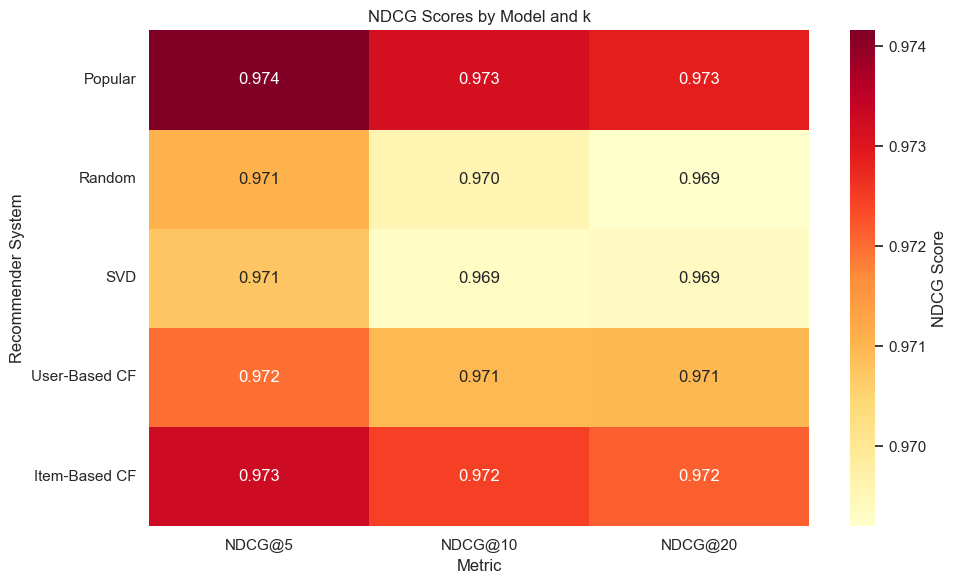

In [214]:
# Create heatmap for NDCG scores
plt.figure(figsize=(10, 6))
sns.heatmap(
    metrics_df[ndcg_cols],
    annot=True,
    fmt=".3f",
    cmap="YlOrRd",
    cbar_kws={"label": "NDCG Score"},
)
plt.title("NDCG Scores by Model and k")
plt.ylabel("Recommender System")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

#### Precision@k and Recall@k

In [215]:
# 3. Precision and Recall Visualization
print("\n=== Precision and Recall Metrics ===")
precision_cols = [col for col in metrics_df.columns if col.startswith("Precision")]
recall_cols = [col for col in metrics_df.columns if col.startswith("Recall")]
display(metrics_df[precision_cols + recall_cols])


=== Precision and Recall Metrics ===


,Precision@5,Precision@10,Precision@20,Recall@5,Recall@10,Recall@20
Popular,0.683656,0.681666,0.681089,0.688827,0.693098,0.694855
Random,0.578065,0.575382,0.574201,0.581322,0.584333,0.585360
SVD,0.778116,0.777910,0.777660,0.784470,0.790273,0.792466
User-Based CF,0.778737,0.777979,0.777323,0.785085,0.790454,0.792247
Item-Based CF,0.781254,0.780543,0.780343,0.787661,0.793354,0.795697


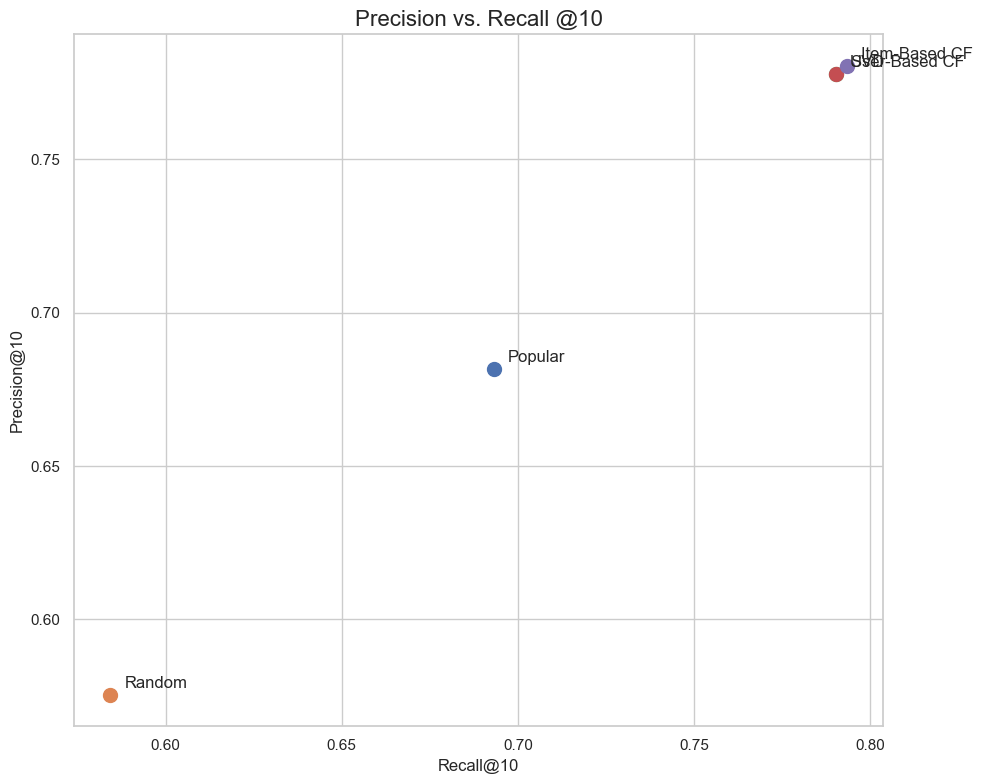

In [216]:
# Precision vs. Recall@10 scatter plot
plt.figure(figsize=(10, 8))
for i, model in enumerate(metrics_df.index):
    plt.scatter(
        metrics_df.loc[model, "Recall@10"],
        metrics_df.loc[model, "Precision@10"],
        s=100,
        label=model,
    )
    plt.annotate(
        model,
        (metrics_df.loc[model, "Recall@10"], metrics_df.loc[model, "Precision@10"]),
        xytext=(10, 5),
        textcoords="offset points",
    )

plt.title("Precision vs. Recall @10", fontsize=16)
plt.xlabel("Recall@10")
plt.ylabel("Precision@10")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Mean Average Precision (MAP)


In [217]:
# 4. Mean Average Precision Visualization
print("\n=== Mean Average Precision (MAP) ===")
display(metrics_df[["MAP"]])


=== Mean Average Precision (MAP) ===


,MAP
Popular,0.789748
Random,0.786642
SVD,0.788282
User-Based CF,0.788736
Item-Based CF,0.788660


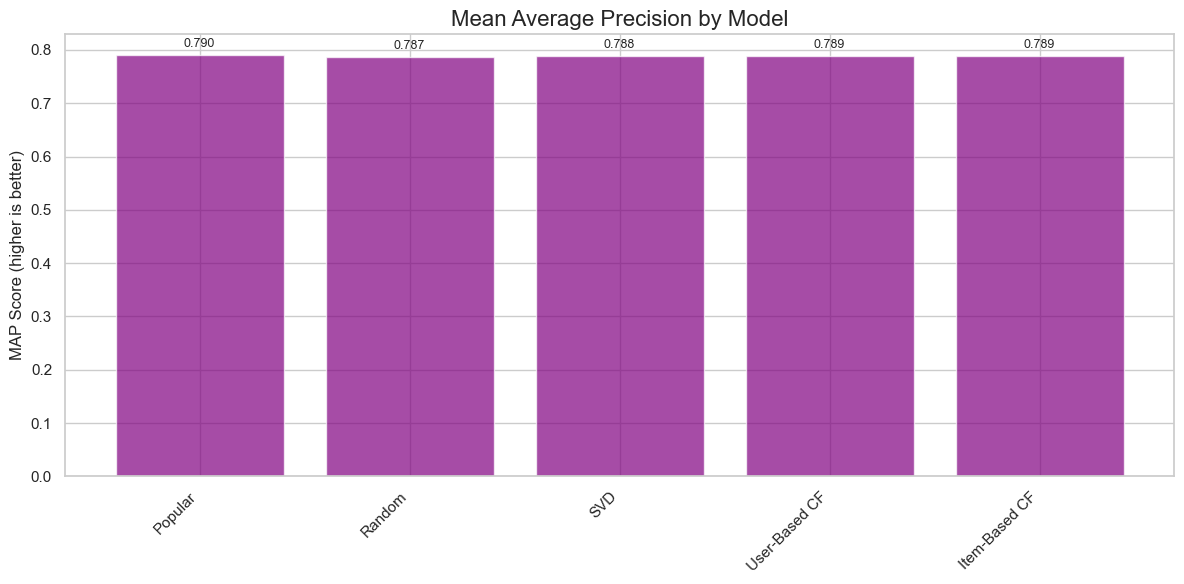

In [218]:
plt.figure(figsize=(12, 6))
plt.bar(metrics_df.index, metrics_df["MAP"], color="purple", alpha=0.7)
plt.title("Mean Average Precision by Model", fontsize=16)
plt.ylabel("MAP Score (higher is better)")
plt.xticks(rotation=45, ha="right")

# Add value labels
for i, v in enumerate(metrics_df["MAP"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

#### Coverage and Diversity

In [219]:
# 5. Coverage Visualization
print("\n=== Coverage Metrics ===")
display(metrics_df[["Coverage (%)"]])


=== Coverage Metrics ===


,Coverage (%)
Popular,37.570562
Random,35.124399
SVD,44.982229
User-Based CF,44.814970
Item-Based CF,45.567635


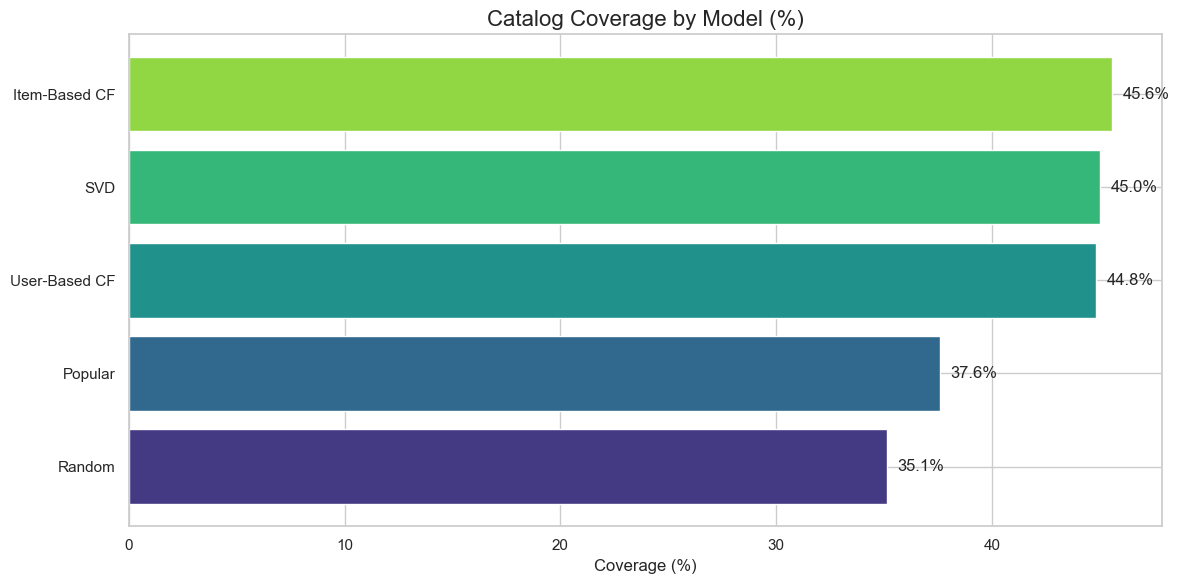

In [220]:
# Sort models by coverage
coverage_sorted = metrics_df.sort_values("Coverage (%)")

plt.figure(figsize=(12, 6))
plt.barh(
    coverage_sorted.index,
    coverage_sorted["Coverage (%)"],
    color=sns.color_palette("viridis", len(metrics_df)),
)
plt.title("Catalog Coverage by Model (%)", fontsize=16)
plt.xlabel("Coverage (%)")

# Add value labels
for i, v in enumerate(coverage_sorted["Coverage (%)"]):
    plt.text(v + 0.5, i, f"{v:.1f}%", va="center")

plt.tight_layout()
plt.show()

## Results